# Exploring CTA IRFs and computing sensitivity

This notebook shows how to explore CTA IRFs and compute sensitivity

In [1]:
from gammapy.utils.check import check_tutorials_setup

check_tutorials_setup()


System:

	python_executable      : /Users/atreyeesinha/anaconda3/envs/gammapy-1.2/bin/python 
	python_version         : 3.10.13    
	machine                : arm64      
	system                 : Darwin     


Gammapy package:

	version                : 1.2        
	path                   : /Users/atreyeesinha/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy 


Other packages:

	numpy                  : 1.26.4     
	scipy                  : 1.12.0     
	astropy                : 6.0.0      
	regions                : 0.8        
	click                  : 8.1.7      
	yaml                   : 6.0.1      
	IPython                : 8.20.0     
	jupyterlab             : 4.0.13     
	matplotlib             : 3.8.3      
	pandas                 : 2.1.4      
	healpy                 : 1.16.6     
	iminuit                : 2.24.0     
	sherpa                 : 4.16.0     
	naima                  : 0.10.0     
	emcee                  : 3.1.4      
	corner                 : 2.2.2  

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord

# %matplotlib inline
from regions import CircleSkyRegion
import matplotlib.pyplot as plt

In [3]:
from IPython.display import display
from gammapy.data import FixedPointingInfo, Observation, observatory_locations
from gammapy.datasets import SpectrumDataset, SpectrumDatasetOnOff
from gammapy.estimators import FluxPoints, SensitivityEstimator
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import SpectrumDatasetMaker
from gammapy.maps import MapAxis, RegionGeom
from gammapy.maps.axes import UNIT_STRING_FORMAT

## Exlpore IRFs

In [4]:
irfs = load_irf_dict_from_file(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [5]:
irfs

{'aeff': <gammapy.irf.effective_area.EffectiveAreaTable2D at 0x15aec3d90>,
 'psf': <gammapy.irf.psf.parametric.EnergyDependentMultiGaussPSF at 0x15af17c10>,
 'edisp': <gammapy.irf.edisp.core.EnergyDispersion2D at 0x15af16d70>,
 'bkg': <gammapy.irf.background.Background3D at 0x15af15960>}

In [6]:
aeff = irfs["aeff"]
aeff

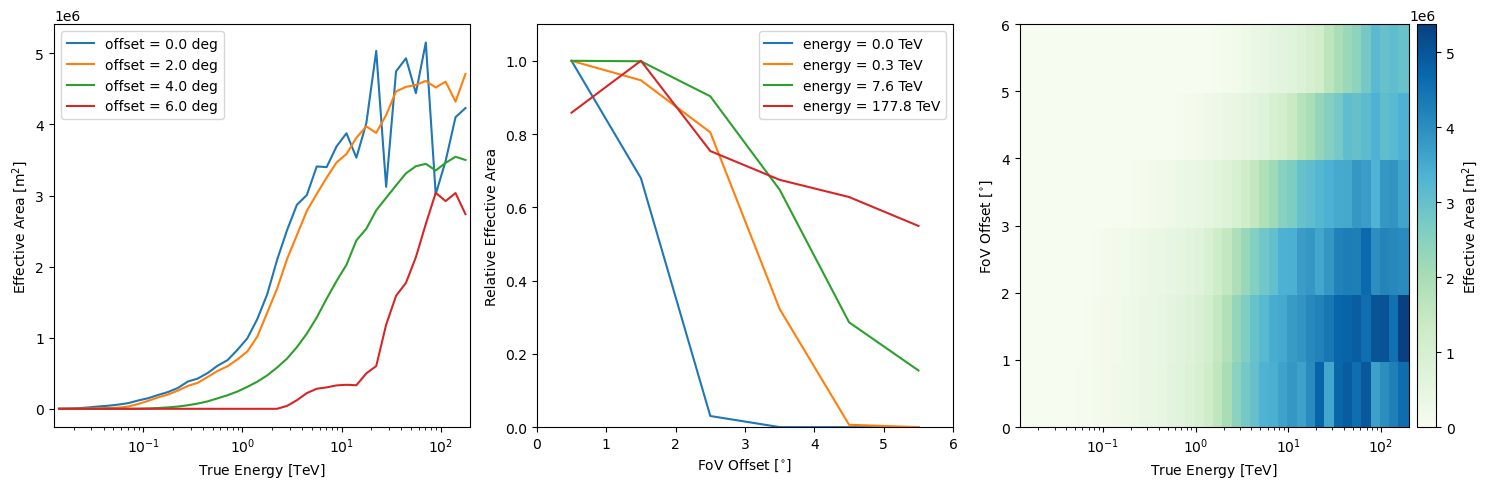

In [7]:
aeff.peek()

In [8]:
energy_true=[0.1, 1, 10, 20]*u.TeV
offset=[0, 1] * u.deg
aeff.evaluate(energy_true=energy_true.reshape(1,-1), offset=offset.reshape(-1,1))

<Quantity [[ 133276.58500382,  910560.40746804, 3783587.001383  ,
            4535448.13249494],
           [ 115297.3001013 ,  859107.53225137, 3695335.75154763,
            4283534.78724174]] m2>

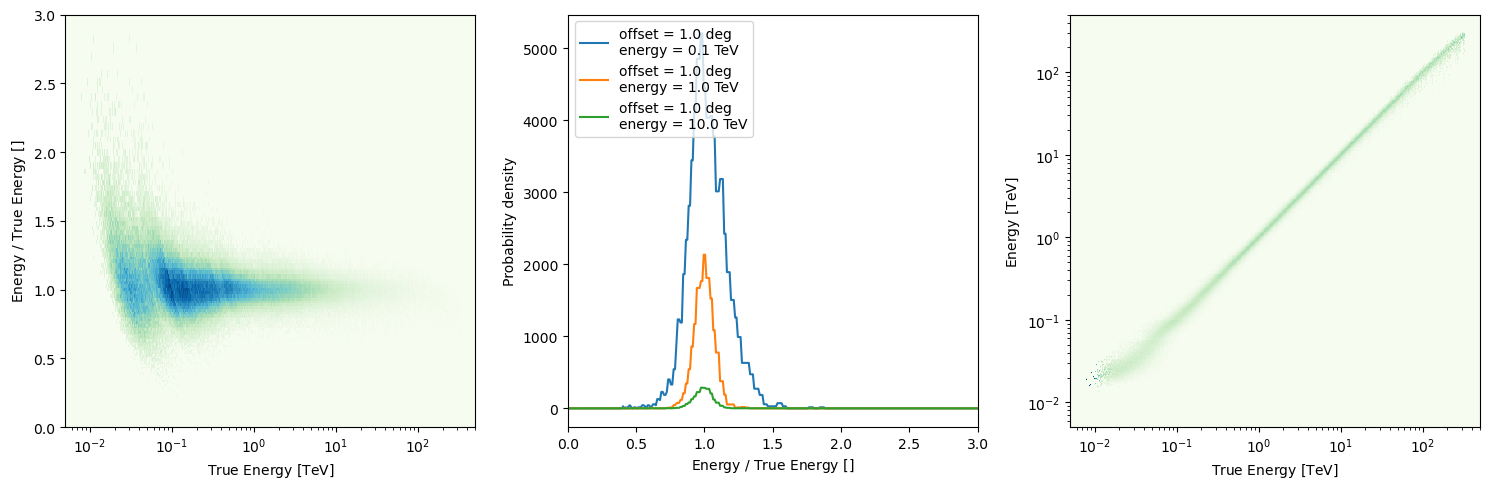

In [9]:
i = irfs["edisp"]
i.peek()

### Questions
1. What is the energy at which the effective area drops to 10% of its maximum value (at 1 deg offset)
2. At what distance from the camera center does the effective area drop to 50% of its value?
3. How does the containment radius change with energy ?
4. What radius is necessry to obtain 99% of the counts at 100 GeV ?
5. Investigate the energy migration at low energies

## Compute sensitivty

This notebook explains how to estimate the CTA sensitivity for a 
**point-like IRF** at a **fixed zenith angle** and **fixed offset**, using the full containment IRFs distributed for the CTA 1DC. The significance is computed for a **1D analysis** (ON-OFF regions) with the **Li&Ma formula**.

We use here an **approximate approach** with an **energy dependent integration radius** to take into account the variation of the PSF. We will first determine the 1D IRFs including a containment correction.

In [10]:
# Analysis region and binning

energy_min = 20*u.GeV
energy_max= 200*u.TeV
energy_axis = MapAxis.from_energy_bounds(energy_min, energy_max, nbin=10,
                                         per_decade=True)
energy_axis_true = MapAxis.from_energy_bounds(
    energy_min=energy_min/2.0, 
    energy_max=energy_max*2.0, 
    nbin=20, per_decade=True,
    name="energy_true"
)

pointing = SkyCoord(ra=0 * u.deg, dec=0 * u.deg)
pointing_info = FixedPointingInfo(fixed_icrs=pointing)

offset = 0.5 * u.deg

source_position = pointing.directional_offset_by(0 * u.deg, offset)

on_region_radius = 0.1 * u.deg
on_region = CircleSkyRegion(source_position, radius=on_region_radius)

geom = RegionGeom.create(on_region, axes=[energy_axis])
empty_dataset = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

In [11]:
location = observatory_locations["cta_north"]

In [12]:
livetime = 50.0 * u.h
obs = Observation.create(
    pointing=pointing_info, irfs=irfs, livetime=livetime, location=location
)

### Create spectrum datasets

- ensure `containment_correction=False` which allows us to apply our own containment correction in the next part of the tutorial.
- If `containment_correction=True`, the exposure is corrected for the psf containment fraction at the given coordinates. This is correct during a spectral analysis, where the counts and background are corrected during the 

In [13]:
spectrum_maker = SpectrumDatasetMaker(
    selection=["exposure", "edisp", "background"],
    containment_correction=False,
)
dataset = spectrum_maker.run(empty_dataset, obs)
dataset

- correct the exposure
- compute containment radius from the PSF
- correct the background

In [14]:
containment = 0.68
dataset.exposure *= containment

on_radii = obs.psf.containment_radius(
    energy_true=energy_axis.center, offset=offset, fraction=containment
)
factor = (1 - np.cos(on_radii)) / (1 - np.cos(on_region_radius))

dataset.background *= factor.value.reshape((-1, 1, 1))



In [15]:
on_radii

<Quantity [0.28425, 0.26575, 0.24575, 0.22025, 0.18975, 0.16375, 0.14175,
           0.12475, 0.11275, 0.10175, 0.09075, 0.08125, 0.07325, 0.06625,
           0.06075, 0.05625, 0.05275, 0.05125, 0.05125, 0.05025, 0.04925,
           0.04825, 0.04675, 0.04475, 0.04225, 0.03975, 0.03775, 0.03625,
           0.03525, 0.03475, 0.03425, 0.03425, 0.03425, 0.03425, 0.03375,
           0.03525, 0.03825, 0.04175, 0.04575, 0.04925] deg>

In [16]:
on_region_radius

<Quantity 0.1 deg>

In [17]:
dataset

- define a `SpectrumDatasetOnOff` with a given acceptance. The off counts are created from the background model

In [18]:
dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=dataset, acceptance=1, acceptance_off=5
)

In [19]:
dataset_on_off

### Use sensitivity estimator to compute sensitivity

Criteria:
- minimal significance 
- minimal number of expected signal counts
- Excess over background fluctuations

In [20]:
sensitivity_estimator = SensitivityEstimator(
    gamma_min=10,
    n_sigma=5,
    bkg_syst_fraction=0.05,
)
sensitivity_table = sensitivity_estimator.run(dataset_on_off)

In [21]:
sensitivity_table

energy,e_ref,e_min,e_max,e2dnde,excess,background,criterion
TeV,TeV,TeV,TeV,erg / (s cm2),,,
float64,float64,float64,float64,float64,float64,float64,bytes12
0.0224404,0.0224404,0.02,0.0251785,1.69391e-11,909.891,18197.8,bkg
0.0282508,0.0282508,0.0251785,0.0316979,1.12614e-11,1417.79,28355.9,bkg
0.0355656,0.0355656,0.0316979,0.0399052,8.2536e-12,1132.64,22652.8,bkg
0.0447744,0.0447744,0.0399052,0.0502377,5.76919e-12,748.817,14976.3,bkg
0.0563677,0.0563677,0.0502377,0.0632456,3.87822e-12,496.124,8013.14,significance
0.0709627,0.0709627,0.0632456,0.0796214,2.20306e-12,388.96,4893.16,significance
...,...,...,...,...,...,...,...
56.3677,56.3677,50.2377,63.2456,6.31469e-13,10,0.0155071,gamma


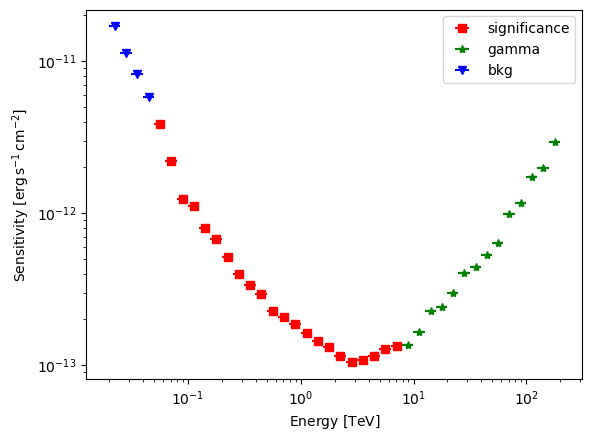

In [22]:

from cycler import cycler

fig, ax = plt.subplots()

ax.set_prop_cycle(cycler("marker", "s*v") + cycler("color", "rgb"))

for criterion in ("significance", "gamma", "bkg"):

    mask = sensitivity_table["criterion"] == criterion
    t = sensitivity_table[mask]

    ax.errorbar(
        t["e_ref"],
        t["e2dnde"],
        xerr=0.5 * (t["e_max"] - t["e_min"]),
        label=criterion,
        linestyle="",
    )

ax.loglog()

ax.set_xlabel(f"Energy [{t['e_ref'].unit.to_string(UNIT_STRING_FORMAT)}]")
ax.set_ylabel(f"Sensitivity [{t['e2dnde'].unit.to_string(UNIT_STRING_FORMAT)}]")

ax.legend()

plt.show()

### Compare with Crab like sources

In [23]:
from gammapy.modeling.models import create_crab_spectral_model

In [24]:
crab_model = create_crab_spectral_model()
crab_model

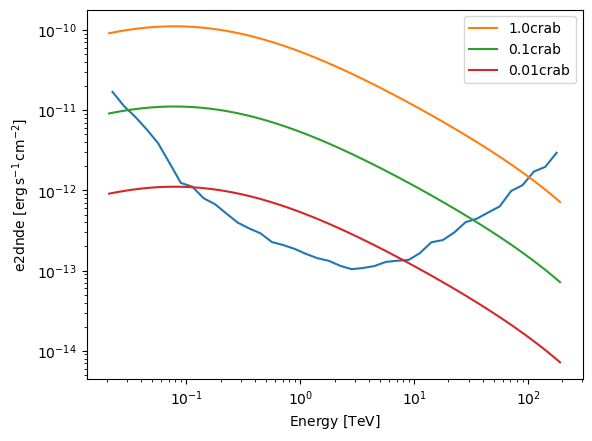

In [25]:

fig, ax = plt.subplots()

plt.plot(sensitivity_table["e_ref"], sensitivity_table["e2dnde"])

ax.loglog()

ax.set_xlabel(f"Energy [{t['e_ref'].unit.to_string(UNIT_STRING_FORMAT)}]")
ax.set_ylabel(f"Sensitivity [{t['e2dnde'].unit.to_string(UNIT_STRING_FORMAT)}]")


for i in range(0,3):
    value = 1.0/np.power(10,i)
    crab_model.norm.value = value
    crab_model.plot(sed_type="e2dnde", energy_bounds=[energy_min, energy_max], 
                    label= str(value) + "crab")

plt.legend()
plt.show()

Questions:

1. How much time will you need to detect a source at 2% of the Crab at 20 TeV
2. Can you detect a 1% Crab source at 100 TeV with CTA?